In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [31]:
#  Load dataset
data = pd.read_csv("Loan_default.csv")
print("Dataset Shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

Dataset Shape: (255347, 18)

First 5 rows:
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes       


Missing Values per Column:
LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


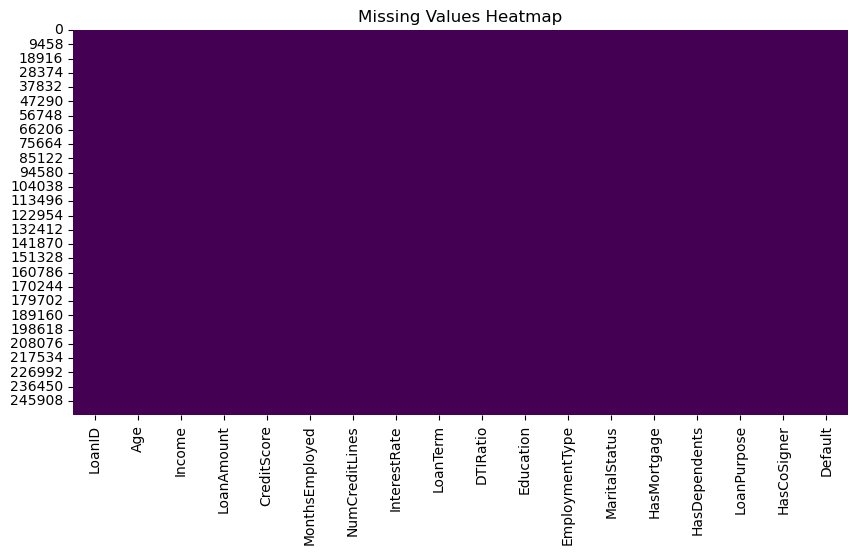

In [33]:
# Check Missing Values
print("\nMissing Values per Column:")
print(data.isnull().sum())

plt.figure(figsize=(10,5))
sns.heatmap(data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [35]:
#  Handle Missing Values
numeric_features = ['Age', 'Income', 'LoanAmount', 'CreditScore',
                    'MonthsEmployed', 'NumCreditLines', 'InterestRate',
                    'LoanTerm', 'DTIRatio']
categorical_features = ['Education', 'EmploymentType', 'MaritalStatus',
                        'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']
target = 'Default'

# Fill missing numeric with median, categorical with mode
for col in numeric_features:
    data[col] = data[col].fillna(data[col].median())
for col in categorical_features:
    data[col] = data[col].fillna(data[col].mode()[0])

print("\n Missing values handled.")


✅ Missing values handled.


In [37]:
# 2. Preprocessing
data = data.drop_duplicates().dropna()
if "LoanID" in data.columns:
    data = data.drop("LoanID", axis=1)

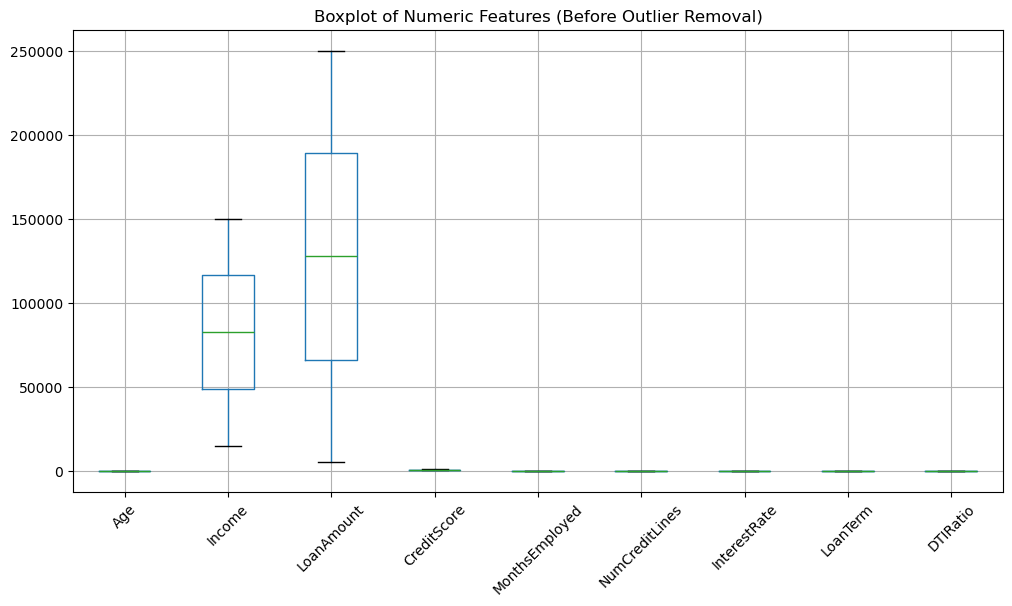

In [39]:
#  Outlier Detection (Before Removal)
plt.figure(figsize=(12,6))
data[numeric_features].boxplot(rot=45)
plt.title("Boxplot of Numeric Features (Before Outlier Removal)")
plt.show()

Data Shape after Outlier Removal: (255347, 17)


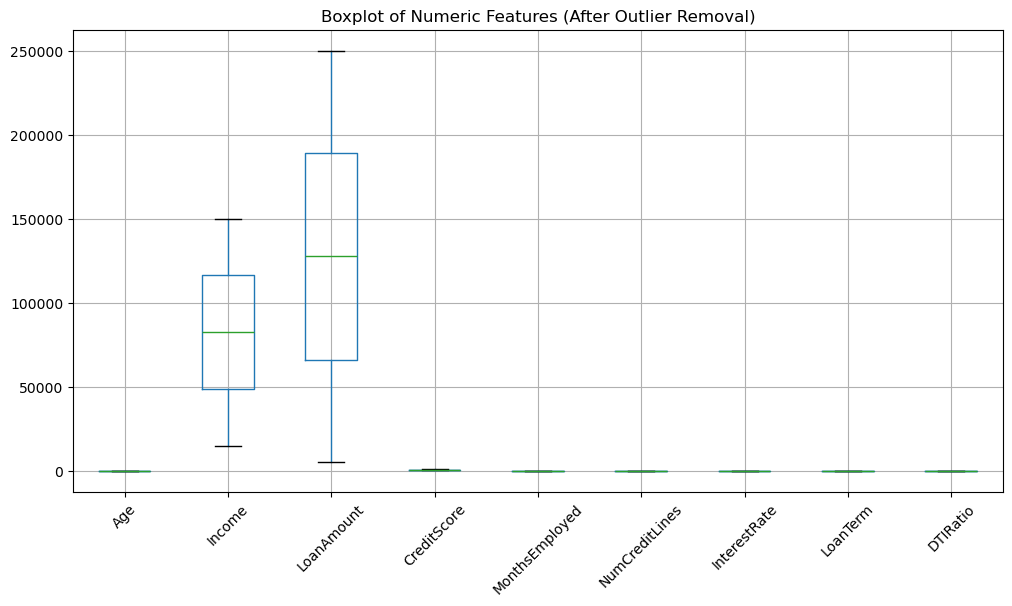

In [41]:
#  Outlier Removal (IQR Method)
for col in numeric_features:
    Q1, Q3 = data[col].quantile(0.25), data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    data = data[(data[col] >= lower) & (data[col] <= upper)]

print("Data Shape after Outlier Removal:", data.shape)

# Check Boxplots again (After Removal)
plt.figure(figsize=(12,6))
data[numeric_features].boxplot(rot=45)
plt.title("Boxplot of Numeric Features (After Outlier Removal)")
plt.show()


Class distribution before balancing:
Default
0    225694
1     29653
Name: count, dtype: int64


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17480\3159985100.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, data=data, palette="Set2")


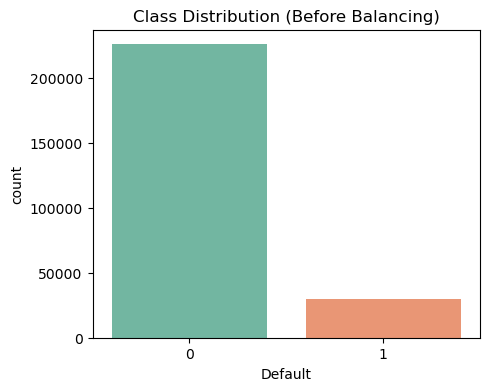

In [43]:
# Check original class distribution
print("\nClass distribution before balancing:")
print(data[target].value_counts())

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.countplot(x=target, data=data, palette="Set2")
plt.title("Class Distribution (Before Balancing)")
plt.show()

In [45]:
# Encode categorical features
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [47]:
# Define features and target
target_column = 'Default'
X = data.drop(target_column, axis=1)
y = data[target_column]

In [49]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [53]:
# 3. Baseline Random Forest
# -----------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1]

print("\n Baseline Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))


 Baseline Random Forest
Accuracy: 0.8856667319365576
ROC-AUC: 0.7344217056746903
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.60      0.05      0.09      5931

    accuracy                           0.89     51070
   macro avg       0.74      0.52      0.51     51070
weighted avg       0.85      0.89      0.84     51070



In [55]:
# 4. Random Forest with Class Weights
# -----------------------------
rf_balanced = RandomForestClassifier(random_state=42, class_weight="balanced")
rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)
y_pred_proba_balanced = rf_balanced.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest (Class Weight Balanced)")
print("Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_balanced))
print(classification_report(y_test, y_pred_balanced))


🔹 Random Forest (Class Weight Balanced)
Accuracy: 0.8853730174270609
ROC-AUC: 0.7344187230743513
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.65      0.03      0.05      5931

    accuracy                           0.89     51070
   macro avg       0.77      0.51      0.50     51070
weighted avg       0.86      0.89      0.84     51070



In [57]:
# 5. Random Forest with SMOTE
# -----------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = rf_smote.predict(X_test)
y_pred_proba_smote = rf_smote.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest (SMOTE Oversampling)")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_smote))
print(classification_report(y_test, y_pred_smote))


🔹 Random Forest (SMOTE Oversampling)
Accuracy: 0.8767573918151557
ROC-AUC: 0.7328350612786538
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     45139
           1       0.41      0.14      0.21      5931

    accuracy                           0.88     51070
   macro avg       0.65      0.56      0.57     51070
weighted avg       0.84      0.88      0.85     51070



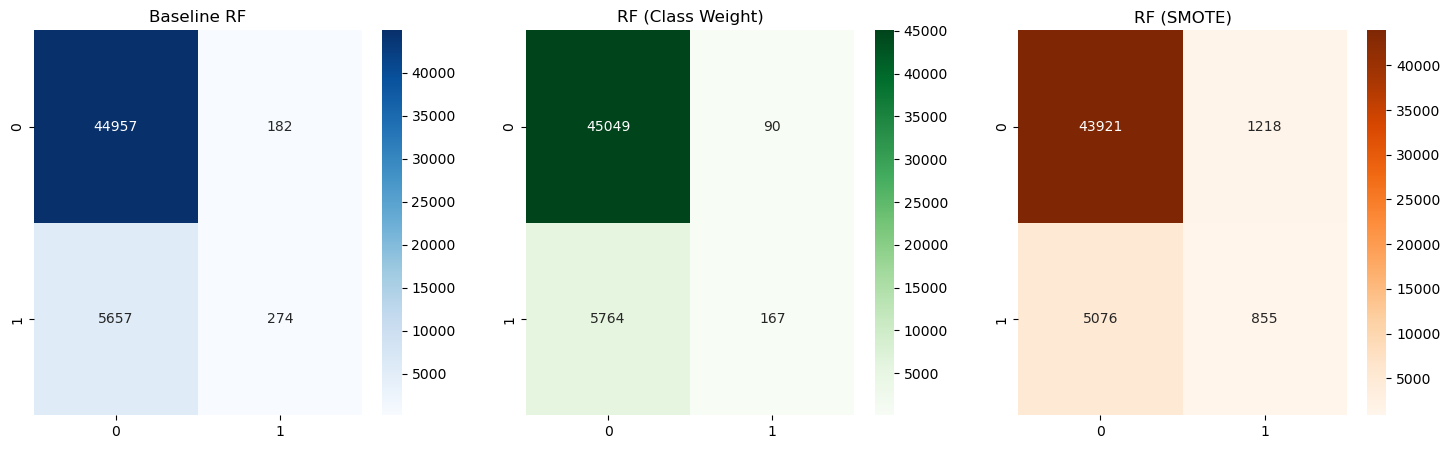

In [59]:
# 6. Confusion Matrices
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Baseline RF")

sns.heatmap(confusion_matrix(y_test, y_pred_balanced), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("RF (Class Weight)")

sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title("RF (SMOTE)")

plt.show()


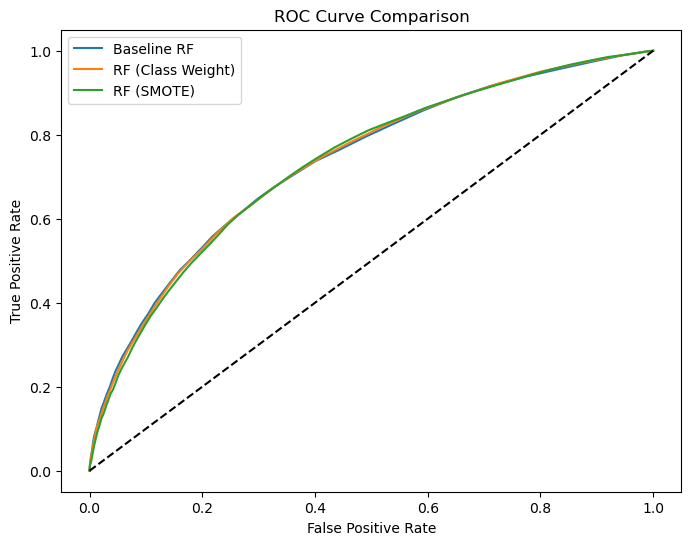

In [61]:
# 7. ROC Curves
# -----------------------------
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
fpr_b, tpr_b, _ = roc_curve(y_test, y_pred_proba_balanced)
fpr_s, tpr_s, _ = roc_curve(y_test, y_pred_proba_smote)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="Baseline RF")
plt.plot(fpr_b, tpr_b, label="RF (Class Weight)")
plt.plot(fpr_s, tpr_s, label="RF (SMOTE)")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

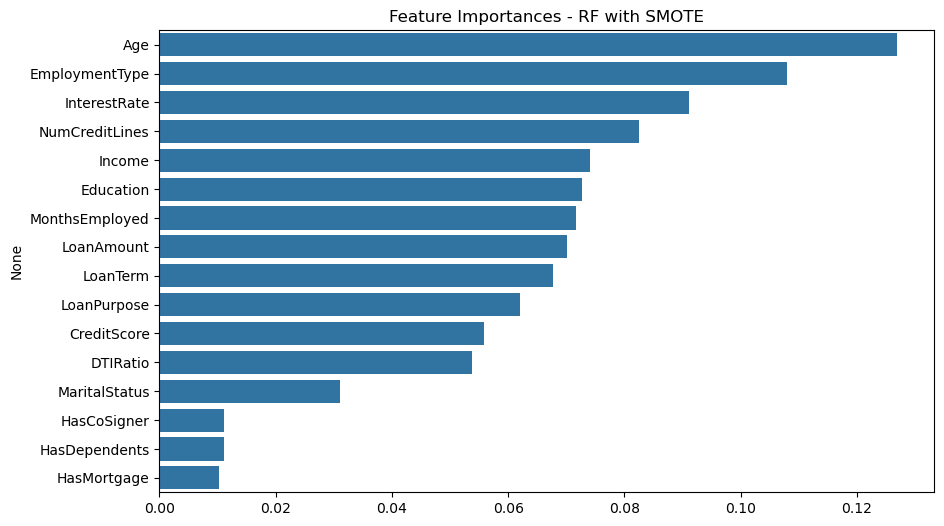

In [67]:
# 8. Feature Importance (using best SMOTE model)
# -----------------------------
importances = rf_smote.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature Importances - RF with SMOTE")
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.show()

In [14]:
# 9. Hyperparameter Tuning (on SMOTE data)
# -----------------------------
#param_grid = {
    #'n_estimators': [100, 200],
    #'max_depth': [None, 10, 20],
    #'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2]
#}
#grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
#grid.fit(X_train_smote, y_train_smote)

#print("\nBest Parameters (RF with SMOTE):", grid.best_params_)
#print("Best CV ROC-AUC:", grid.best_score_)

In [69]:
# Save DataFrame to CSV
data.to_csv("KGpreprocessed_data.csv", index=False)

In [71]:
import joblib, os

# Create folder again
os.makedirs("model_artifacts", exist_ok=True)

# Save model and preprocessing objects correctly
joblib.dump(rf_smote, "model_artifacts/loan_rf_model.pkl")
joblib.dump(scaler, "model_artifacts/scaler.pkl")
joblib.dump(label_encoders, "model_artifacts/label_encoders.pkl")
joblib.dump(list(X.columns), "model_artifacts/features.pkl")

print(" Model and artifacts saved successfully!")



✅ Model and artifacts saved successfully!
